<a target="_blank" href="https://colab.research.google.com/github/rcabanasdepaz/ME-BigData/blob/main/JAGS/Temporal_JAGS.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Modelo temporal con JAGS

In [ ]:
install.packages("R2OpenBUGS")
library(R2OpenBUGS)


system("sudo apt-get install -y jags") # Sólo para colab o sistemas Linux
install.packages("rjags")
library(rjags)


install.packages("coda")
library(coda)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



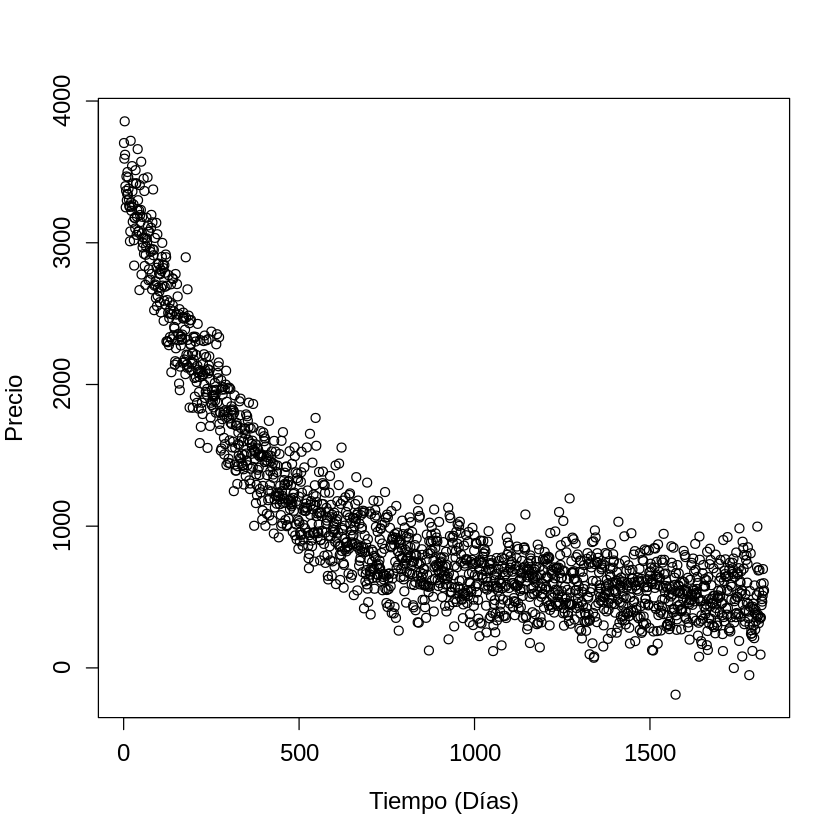

In [ ]:
############## Construcción del conjunto de datos #################################
# Precios de placas solares que bajan con el tiempo

time<-seq(1,5*365)

z = .003 # tasa de depreciación real
b = 500 # precio mínimo plausible en un futuro cercano


price = list()
for (i in 1:length(time)){
  price[i]<-3000*exp(-z*time[i])+b+rnorm(1,0,200)
}

plot(unlist(price), xlab='Tiempo (Días)', ylab='Precio', cex.axis=1.2, cex.lab=1.2)

df = data.frame(Time=unlist(time),Price=unlist(price))


In [ ]:
df

Time,Price
<int>,<dbl>
1,3703.885
2,3593.362
3,3856.878
4,3621.007
5,3399.200
6,3249.846
7,3366.865
8,3468.187
9,3299.586


In [ ]:

# Un modelo en rjags es una función
mod = function(){
  # distribuciones a priori
  b0~dnorm(0,.001)
  Z~dnorm(0,.001)

  sigma~dunif(0,100)
  tau<-1/(sigma*sigma)


  # verosimilitud
  for(i in 1:1825){
    mu[i]<-b0+3000*exp(-Z*Time[i])
    Price[i]~dnorm(mu[i], tau)
    Price_pred[i]~dnorm(mu[i], tau)
  }

}

# hay que guardar el modelo en un archivo
model.file="model.txt"
write.model(mod,model.file)

# la configuración inicial se generará al azar
inits<-NULL



## hiperparámetros
# número de iteraciones de simulación
ni = 10000
# fase de burn-in
nb = 1000

# compilamos el modelo
jmod = jags.model(file = model.file, data = df, inits = inits, n.adapt = 1000)

# iteramos para la fase de calentamiento
update(jmod, n.iter=nb, by=1)

# muestreamos las dist. a posteriori de los parámetros
post = coda.samples(jmod, c("tau","Z", "b0", "Price_pred"), n.iter = ni)



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1825
   Unobserved stochastic nodes: 1828
   Total graph size: 12786

Initializing model



In [ ]:
post$Price_pred

NULL

In [ ]:
# Muestreamos la secuencia completa
samples = jags.samples(jmod,c('b0', 'Z', 'Price_pred'), 100)

# calculamos la media de cada grupo de muestras
posterior_means = apply(samples$Price_pred,1,mean)

In [ ]:
posterior_means

[1] 1825

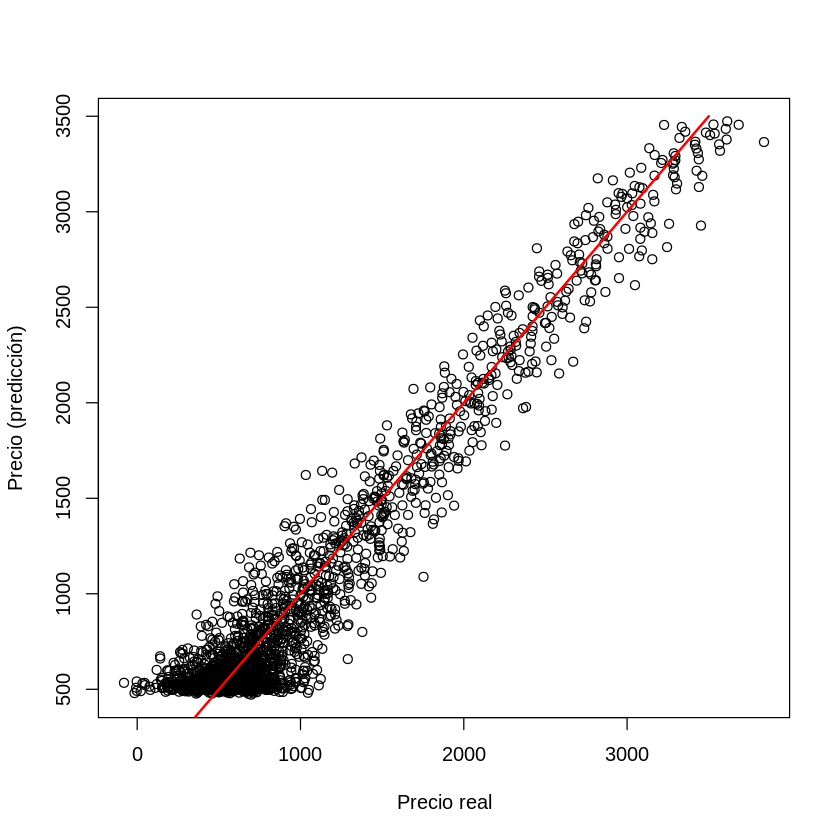

In [ ]:
# mostramos las medias frente a los datos observados
plot(df$Price, posterior_means, ylab='Precio (predicción)', xlab='Precio real')
lines(seq(1,3500),seq(1,3500), col='red', lwd=2, cex=3)